In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import signal

import sys
sys.path.insert(0, '..')
import specsens as ss

---- Simulation parameter ----
Generations:    100
Iterations:     300
Total Iters:    30000
Signal power:   0.00 dB
Noise power:    13.00 dB
Noise uncert.:  0.00 dB
SNR:            -13.00 dB
Signal length:  0.001024 sec
Signal samples: 1024
Num. of bands:  4
Band to detect: 2
---- Simulation stats theory ----
Prob false alarm 0.1000
Prob detection   0.9484
Threshold        5521.0307
---- Running simulation ----
   infs left at  0.00%
 30.20s left at  1.00%
 29.98s left at  2.00%
 32.51s left at  3.00%
 33.70s left at  4.00%
 31.39s left at  5.00%
 29.11s left at  6.00%
 29.09s left at  7.00%
 29.15s left at  8.00%
 27.21s left at  9.00%
 28.59s left at 10.00%
 28.11s left at 11.00%
 28.14s left at 12.00%
 27.61s left at 13.00%
 29.26s left at 14.00%
 27.02s left at 15.00%
 26.27s left at 16.00%
 24.71s left at 17.00%
 25.44s left at 18.00%
 29.52s left at 19.00%
 27.02s left at 20.00%
 23.86s left at 21.00%
 23.48s left at 22.00%
 22.80s left at 23.00%
 23.18s left at 24.00%
 22.64s l

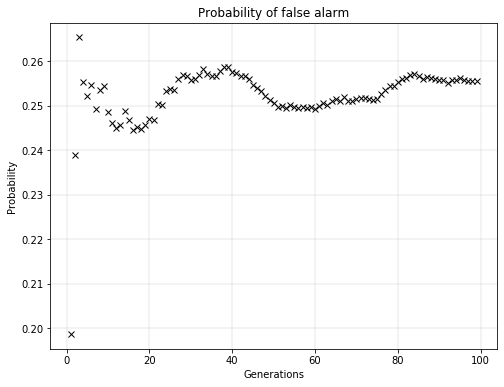

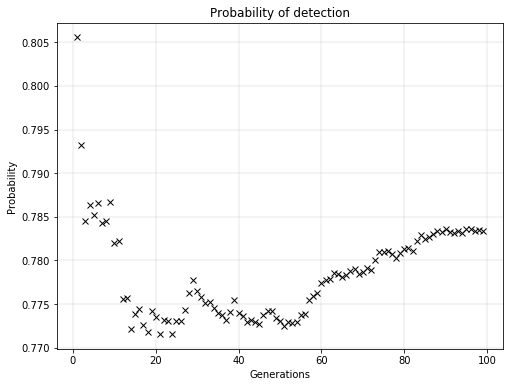

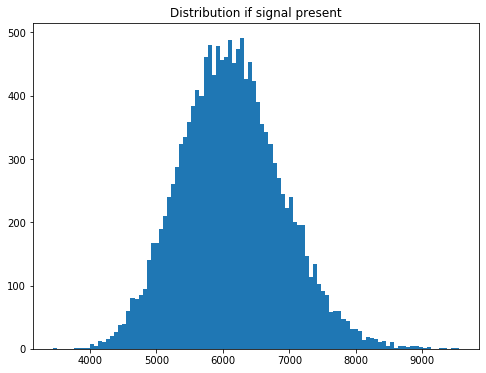

Sig Mean=6131.529, Standard Deviation=767.279


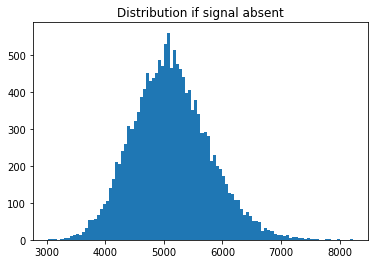

Noise Mean=5118.852, Standard Deviation=650.206


In [5]:
def sim_wide(gens=100,
             itrs=100,
             f_sample=1e6,
             signal_strength=0.,
             noise_strength=0.,
             length_sec=None,
             num_samples=None,
             theo_pfa=0.1,
             threshold=None,
             noise_un=0.,
             bands=1,
             band_to_detect=0,
             nfft=1024):

    # Check and calculate length, in seconds and number of samples
    if num_samples is not None:
        assert num_samples > 0., 'num_samples must be greater than 0'
        length_sec = num_samples / f_sample
    elif length_sec is not None:
        assert length_sec > 0., 'length_sec must be greater than 0'
        length_sec = length_sec
        num_samples = int(f_sample * length_sec)
    else:
        assert False, 'either num_samples or length_sec needed'

    # Calculate threshold
    if threshold is None:
        threshold = ss.chi2_stats.get_thr(noise_power=noise_strength,
                                          pfa=theo_pfa,
                                          n=num_samples // bands,
                                          dB=True)

    print('---- Simulation parameter ----')
    print('Generations:    %d' % (gens))
    print('Iterations:     %d' % (itrs))
    print('Total Iters:    %d' % (gens * itrs))
    print('Signal power:   %.2f dB' % (signal_strength))
    print('Noise power:    %.2f dB' % (noise_strength))
    print('Noise uncert.:  %.2f dB' % (noise_un))
    print('SNR:            %.2f dB' % (signal_strength - noise_strength))
    print('Signal length:  %.6f sec' % (length_sec))
    print('Signal samples: %d' % (num_samples))
    print('Num. of bands:  %d' % (bands))
    print('Band to detect: %d' % (band_to_detect))

    theo_pd = ss.chi2_stats.get_pd(noise_strength,
                                   signal_strength,
                                   threshold,
                                   num_samples // bands,
                                   dB=True,
                                   bands=bands)

    print('---- Simulation stats theory ----')
    print('Prob false alarm %.4f' % (theo_pfa))
    print('Prob detection   %.4f' % (theo_pd))
    print('Threshold        %.4f' % (threshold))

    print('---- Running simulation ----')

    pfas = np.array([])  # Probability of false alarm list
    pds = np.array([])  # Probability of detection list
    en_sig = np.array([])  # Signal energy result list
    en_noise = np.array([])  # Noise energy result list
    current_time = None

    # Calculate noise for each generation
    noise_strength = np.random.normal(noise_strength, noise_un, gens)

    # Create new signal objects
    wm = ss.WirelessMicrophone(f_sample=f_sample, t_sec=length_sec)
    wgn = ss.WhiteGaussianNoise(f_sample=f_sample, t_sec=length_sec)

    # Outer generations loop
    for i in range(gens):

        # Run itertations and store results in result array
        result = np.array([])
        for j in range(itrs):
            result_tmp, en = iteration(wm, wgn, signal_strength, noise_strength[i],
                                threshold, f_sample, nfft, bands,
                                band_to_detect)
            result = np.append(result, result_tmp)
            if result_tmp == 1 or result_tmp == 2:
                en_sig = np.append(en_sig, en)
            else:
                en_noise = np.append(en_noise, en)
            

        # Convert to numpy array
        result = np.asarray(result)

        # Calculate statistics and store in arrays
        pfa_tmp = np.sum(result == 3) / (np.sum(result == 3) +
                                         np.sum(result == 4))
        pd_tmp = np.sum(result == 1) / (np.sum(result == 1) +
                                        np.sum(result == 2))
        pfas = np.append(pfas, pfa_tmp)
        pds = np.append(pds, pd_tmp)

        # Print simulation progress
        rem, percent, current_time = ss.util_sim.runtime_stats(
            current_time, gens, i)
        print('%6.2fs left at %5.2f%%' % (rem, percent))

    # Compute stats from lists
    pfa = np.sum(pfas) / gens
    pd = np.sum(pds) / gens

    print('---- Simulation stats ----')
    print('Prob false alarm theory %.4f' % (theo_pfa))
    print('Prob false alarm sim    %.4f' % (pfa))
    print('Prob detection theory   %.4f' % (theo_pd))
    print('Prob detection sim      %.4f' % (pd))

    ss.util_sim.print_convergence(gens, pfas, pds)
    ss.util_sim.print_distibution(en_sig, en_noise)
    return pfa, pd


def iteration(wm,
              wgn,
              signal_strength,
              noise_strength,
              threshold,
              f_sample=1.e6,
              nfft=1024,
              bands=1,
              band_to_detect=0):

    # Generate signal, center frequency does not matter with single band ED
    sig = wm.get_soft(f_center=1e5, power=signal_strength, dB=True)

    # Generate noise
    noise = wgn.get_signal(power=noise_strength, dB=True)

    # Randomly decide whether signal should be present
    sig_present = bool(np.random.randint(2))
    if sig_present:
        both = sig + noise
    else:
        both = noise

    # Classic (single band) energy detector
    # eng = ss.EnergyDetector.get(both)

    # Mutliband stft based energy detector
    sft = ss.Stft(n=nfft, window='flattop')
    f, psd = sft.stft(sig=both, f_sample=f_sample, normalized=False, dB=False)
    edf = ss.FreqEnergyDetector(num_bands=bands,
                                f_sample=1e6,
                                fft_len=nfft,
                                freqs=f)
    eng = edf.detect(psd)[band_to_detect]

    # Threshold
    sig_detected = eng > threshold

    # Log signal and detection outcome
    if sig_present and sig_detected:
        return 1, eng
    elif sig_present and not sig_detected:
        return 2, eng
    elif not sig_present and sig_detected:
        return 3, eng
    else:
        return 4, eng


# Wide band energy detector simulation
_ = sim_wide(
    gens=100,
    itrs=300,
    f_sample=1e6,  # in Hz
    signal_strength=0.0,  # in dB
    noise_strength=13.0,  # in dB
    num_samples=1024,  # in seconds
    theo_pfa=0.1,  # probability of false alarm
    noise_un=0.0,  # standard deviation of the noise normal distribution
    bands=4,  # number of bands
    band_to_detect=2,  # which band to detect in
    nfft=1024)  # length of fft